In [179]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipaddress

from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

## Data loading

In [180]:
num_samples = 500000
outlier_ratio = 0.4

names = ['end_epoch', 'duration', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'flags', 'status', 'service_type', 'packets', 'bytes', 'attack']

background = pd.read_csv("data/training/background_flows_cut.csv", header=None, names=names, nrows=num_samples)
blacklist = pd.read_csv("data/training/blacklist_flows_cut.csv", header=None, names=names, nrows=num_samples * outlier_ratio / 2)
sshscan = pd.read_csv("data/training/sshscan_flows_cut.csv", header=None, names=names, nrows=num_samples * outlier_ratio / 2)
spam = pd.read_csv("data/training/spam_flows_cut.csv", header=None, names=names)

df = pd.concat([background, blacklist, spam, sshscan], ignore_index=True)

# Convert timestamp to epoch integer
df.end_epoch = pd.to_datetime(df.end_epoch).astype(np.int64)

# Convert attack to boolean
df.attack = df.attack.apply(lambda x: x != 'background')

# Convert IPs to int
df.src_ip = df.src_ip.apply(lambda x: np.int64(ipaddress.IPv4Address(x)))
df.dst_ip = df.src_ip.apply(lambda x: np.int64(ipaddress.IPv4Address(x)))

df.head()

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,protocol,flags,status,service_type,packets,bytes,attack
0,1460937720000000000,55.952,719034749,719034749,32004,55116,TCP,.A....,0,0,29544,1197024,False
1,1460937721000000000,13.148,2403862665,2403862665,53,56415,UDP,.A....,0,0,2,250,False
2,1460937721000000000,13.160,2403862665,2403862665,53,42993,UDP,.A....,0,0,2,256,False
3,1460937722000000000,12.704,2403862665,2403862665,53,49453,UDP,.A....,0,0,2,256,False
4,1460937722000000000,13.196,2403862665,2403862665,53,49998,UDP,.A....,0,0,2,256,False


## Dataset Observations

In [181]:
print(f'Size of the dataset: {len(df)}\n')
print(f'Sumber of Nan values: {df.isnull().values.sum()}\n')
print(f'Column number: {len(df.columns)}\n')
print(f'Column names:\n{list(df.columns)}\n')
print('Column types:')
df.dtypes

Size of the dataset: 677741

Sumber of Nan values: 0

Column number: 13

Column names:
['end_epoch', 'duration', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'flags', 'status', 'service_type', 'packets', 'bytes', 'attack']

Column types:


end_epoch         int64
duration        float64
src_ip            int64
dst_ip            int64
src_port          int64
dst_port          int64
protocol         object
flags            object
status            int64
service_type      int64
packets           int64
bytes             int64
attack             bool
dtype: object

#### Control of flows

In [182]:
print(f"Number of background exchanges : {len(df[df.attack == False])}")
print(f"Number of attack: {len(df[df.attack])}")
print(f"Number of blacklisted IP attack: {len(blacklist)}")
print(f"Number of ssh scan attack: {len(sshscan)}")
print(f"Number of spam attack: {len(spam)}")

Number of background exchanges : 477700
Number of attack: 200041
Number of blacklisted IP attack: 100000
Number of ssh scan attack: 100000
Number of spam attack: 41


#### Numeric columns

In [183]:
numeric_df = df._get_numeric_data()
numeric_df.describe()

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,status,service_type,packets,bytes
count,6.777410e+05,677741.000000,6.777410e+05,6.777410e+05,677741.000000,677741.000000,677741.0,677741.000000,677741.000000,6.777410e+05
mean,1.460959e+18,3.440889,1.517121e+09,1.517121e+09,23000.738350,20556.502573,0.0,9.270333,18.628576,1.156331e+04
std,5.357125e+13,17.038651,1.142320e+09,1.142320e+09,24182.880789,24010.337117,0.0,19.890620,944.859442,9.003700e+05
min,1.460938e+18,0.000000,5.397147e+08,5.397147e+08,0.000000,0.000000,0.0,0.000000,1.000000,2.700000e+01
25%,1.460938e+18,0.000000,7.190356e+08,7.190356e+08,53.000000,53.000000,0.0,0.000000,1.000000,7.600000e+01
50%,1.460938e+18,0.188000,7.190363e+08,7.190363e+08,10656.000000,445.000000,0.0,0.000000,4.000000,3.980000e+02
75%,1.460938e+18,3.528000,2.403863e+09,2.403863e+09,48342.000000,45930.000000,0.0,8.000000,12.000000,1.589000e+03
max,1.461503e+18,355.724000,4.294822e+09,4.294822e+09,65535.000000,65535.000000,0.0,224.000000,466815.000000,5.355177e+08


## Dataset Visualisation

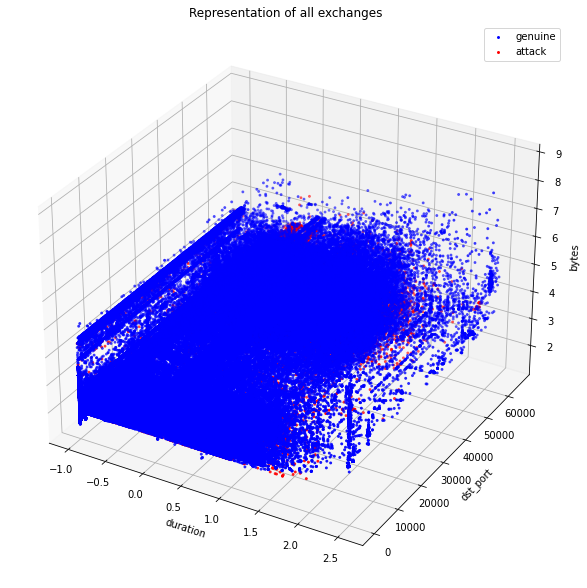

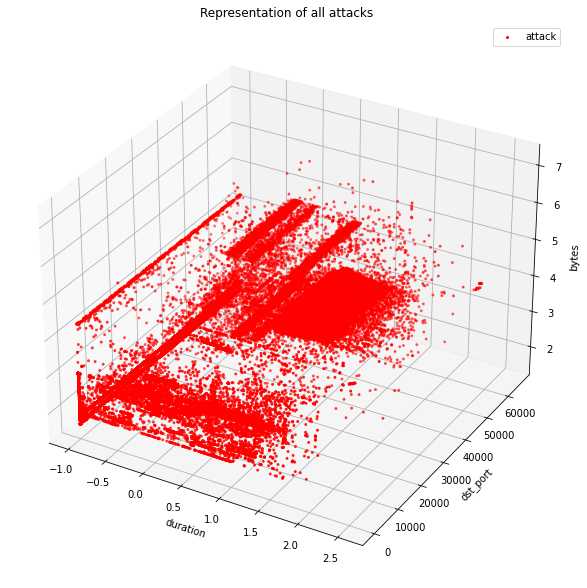

In [184]:
def show3D_flow_exchanges(df, x_axis, y_axis, z_axis, title):
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(111, projection='3d')

    for attack in df.attack.unique():
        df_label = df[df.attack == attack]
        x = df_label[x_axis]
        y = df_label[y_axis]
        z = df_label[z_axis]
        ax.scatter(np.log10(x + 0.1), y, np.log10(z), color= 'red' if attack else 'blue' , label='attack' if attack else 'genuine', marker='.', s=15)

    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.set_zlabel(z_axis)
    ax.set_title(title)

    plt.legend()

show3D_flow_exchanges(df, 'duration', 'dst_port', 'bytes', 'Representation of all exchanges')
show3D_flow_exchanges(df[df.attack], 'duration', 'dst_port', 'bytes', 'Representation of all attacks')

## Data Cleaning

In [185]:
one_hot_encoded_df = pd.get_dummies(df)
display(one_hot_encoded_df.head())
print(one_hot_encoded_df.isna().sum().any())

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,status,service_type,packets,bytes,...,flags_.A.RS.,flags_.A.RSF,flags_.AP...,flags_.AP..F,flags_.AP.S.,flags_.AP.SF,flags_.APR..,flags_.APR.F,flags_.APRS.,flags_.APRSF
0,1460937720000000000,55.952,719034749,719034749,32004,55116,0,0,29544,1197024,...,0,0,0,0,0,0,0,0,0,0
1,1460937721000000000,13.148,2403862665,2403862665,53,56415,0,0,2,250,...,0,0,0,0,0,0,0,0,0,0
2,1460937721000000000,13.160,2403862665,2403862665,53,42993,0,0,2,256,...,0,0,0,0,0,0,0,0,0,0
3,1460937722000000000,12.704,2403862665,2403862665,53,49453,0,0,2,256,...,0,0,0,0,0,0,0,0,0,0
4,1460937722000000000,13.196,2403862665,2403862665,53,49998,0,0,2,256,...,0,0,0,0,0,0,0,0,0,0


False


## Outlier detection

#### Isolation Forests

In [194]:
classifier = IsolationForest(contamination=outlier_ratio)
classifier.fit(one_hot_encoded_df.values)
y_pred = classifier.predict(one_hot_encoded_df.values)

df_outliers = one_hot_encoded_df.copy()
df_outliers['if_outliers'] = [i == -1 for i in  y_pred]
df_outliers

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,status,service_type,packets,bytes,...,flags_.A.RSF,flags_.AP...,flags_.AP..F,flags_.AP.S.,flags_.AP.SF,flags_.APR..,flags_.APR.F,flags_.APRS.,flags_.APRSF,if_outliers
0,1460937720000000000,55.952,719034749,719034749,32004,55116,0,0,29544,1197024,...,0,0,0,0,0,0,0,0,0,True
1,1460937721000000000,13.148,2403862665,2403862665,53,56415,0,0,2,250,...,0,0,0,0,0,0,0,0,0,True
2,1460937721000000000,13.160,2403862665,2403862665,53,42993,0,0,2,256,...,0,0,0,0,0,0,0,0,0,True
3,1460937722000000000,12.704,2403862665,2403862665,53,49453,0,0,2,256,...,0,0,0,0,0,0,0,0,0,True
4,1460937722000000000,13.196,2403862665,2403862665,53,49998,0,0,2,256,...,0,0,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677736,1460939063000000000,4.376,719035623,719035623,60978,22,0,0,12,1253,...,0,0,0,0,1,0,0,0,0,False
677737,1460939062000000000,3.448,719035623,719035623,59975,22,0,0,12,1253,...,0,0,0,0,1,0,0,0,0,False
677738,1460939063000000000,4.304,719035623,719035623,35883,22,0,0,12,1253,...,0,0,0,0,1,0,0,0,0,False
677739,1460939064000000000,5.244,719035623,719035623,45884,22,0,0,12,1253,...,0,0,0,0,1,0,0,0,0,False


In [200]:
fraudulent_outliers = df_outliers[(df_outliers.attack) & (df_outliers.if_outliers)]
print(f'{len(fraudulent_outliers)} attacks are labelled as outlier.')

fraudulent_inliers = df_outliers[(df_outliers.attack) & (df_outliers.if_outliers == False)]
print(f'{len(fraudulent_inliers)} attacks are not labelled as outlier.')

not_fraudulent_outliers = df_outliers[(df_outliers.attack == False) & (df_outliers.if_outliers)]
print(f'{len(not_fraudulent_outliers)} genuine exchanges are labelled as outlier.')

not_fraudulent_inliers = df_outliers[(df_outliers.attack == False) & (df_outliers.if_outliers == False)]
print(f'{len(not_fraudulent_inliers)} genuine exchanges are not labelled as outlier.')

107879 attacks are labelled as outlier.
92162 attacks are not labelled as outlier.


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().